In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import random
import tensorflow as tf
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization, Activation, Convolution2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, Conv2D

In [ ]:
IMG_SIZE = 256
EPOCHS = 250
BATCH_SIZE = 32

In [ ]:
# # Set base directory to the current working directory
# base_dir = Path.cwd()

# # Define key directories
# spectrogram_dir = base_dir / 'spectrogram'
# data_dir = base_dir / 'data'
# train_dir = data_dir / 'train'
# test_dir = data_dir / 'test'

# # Create data/train and data/test directories if they do not exist
# for directory in [train_dir, test_dir]:
#     os.makedirs(directory, exist_ok=True)

# # List category subdirectories in the spectrogram directory
# categories = [d for d in spectrogram_dir.iterdir() if d.is_dir()]

# # For each category, split files into train/test and copy them
# for category in categories:
#     files = list(categoriley.glob('*.*'))  # Handles any file extension
#     random.shuffle(files)

#     split_idx = int(len(fs) * 0.8)
#     train_files = files[:split_idx]
#     test_files = files[split_idx:]

#     # Create category subfolders in train/test
#     category_name = category.name
#     os.makedirs(train_dir / category_name, exist_ok=True)
#     os.makedirs(test_dir / category_name, exist_ok=True)

#     # Copy files to train and test directories
#     for f in train_files:
#         shutil.copy(f, train_dir / category_name / f.name)
#     for f in test_files:
#         shutil.copy(f, test_dir / category_name / f.name)

# print("✅ Dataset successfully split into train and test folders.")

In [ ]:
base_dir = 'drive/MyDrive/data'
# base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print(class_names)
print(num_classes)

['Animals', 'Exterior', 'Human, non-speech sounds', 'Interior', 'Natural soundscapes & water sounds']
5


In [ ]:
class_counts = {}

for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)

  if os.path.isdir(train_dir):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images)

print("\n")
print("Class Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" *45)



Class Distribution:
Class Name               Valid Image Count
Animals                              320
Exterior                             320
Human, non-speech sounds             320
Interior                             320
Natural soundscapes & water sounds            320


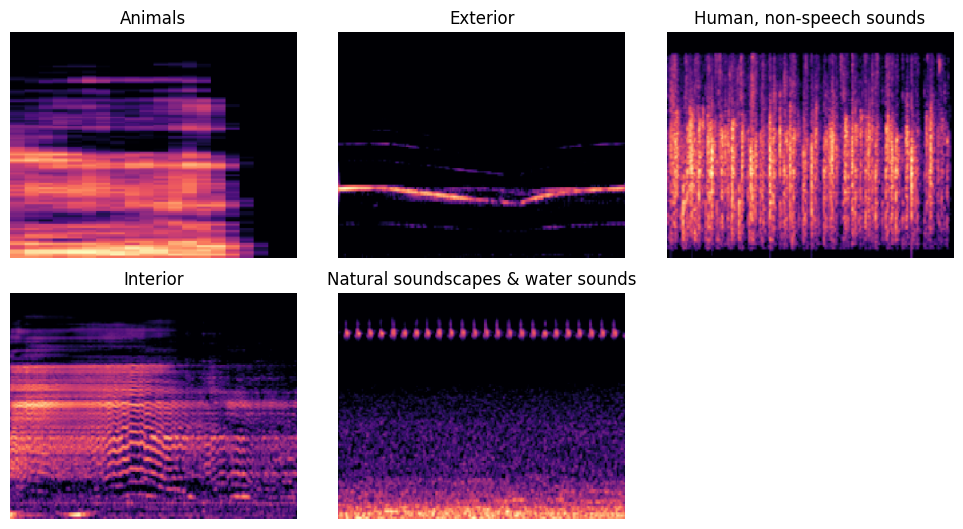

In [ ]:
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
  class_dir = os.path.join (train_dir, class_name)
  images = os.listdir(class_dir)
  img_name = random.choice(images)
  img_path = os.path.join(class_dir, img_name)
  img = Image.open(img_path)

  plt.subplot(3, 3, i + 1)
  plt.imshow(img)
  plt.title(class_name)
  plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
corrupted = []
for class_name in class_names:
  class_dir = os.path.join(train_dir, class_name)
  for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    try:
      img = Image.open(img_path)
      img.verify()
    except:
      corrupted.append(img_path)
      os.remove(img_path)
      print(f"Removed corrupted image:{img_path}")

if not corrupted:
  print("No corrupted images found.")

No corrupted images found.


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# Function to evaluate and plot confusion matrix for a model
def evaluate_model_and_plot_confusion_matrix(model, val_ds, class_names, model_name):
    y_true = []
    y_pred = []

    # Get the true and predicted labels for the validation dataset
    for images, labels in val_ds:
        preds = model.predict(images)
        preds_labels = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds_labels)

    # Plot the confusion matrix for the current model
    plot_confusion_matrix(y_true, y_pred, class_names, model_name)

In [ ]:
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [ ]:
# ------ Integrate the TensorFlow Dataset Code Below ------

# Parameters for resizing and batching
img_height, img_width = IMG_SIZE, IMG_SIZE
batch_size = BATCH_SIZE
validation_split = 0.2

# Rescaling layer to normalize the images
rescale = tf.keras.layers.Rescaling(1./255)

# Creating the training dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=111
)


# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='validation',
    seed=111
)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

print("✅ Datasets successfully created for training and validation.")

Found 1600 files belonging to 5 classes.
Using 1280 files for training.
Found 1600 files belonging to 5 classes.
Using 320 files for validation.
✅ Datasets successfully created for training and validation.


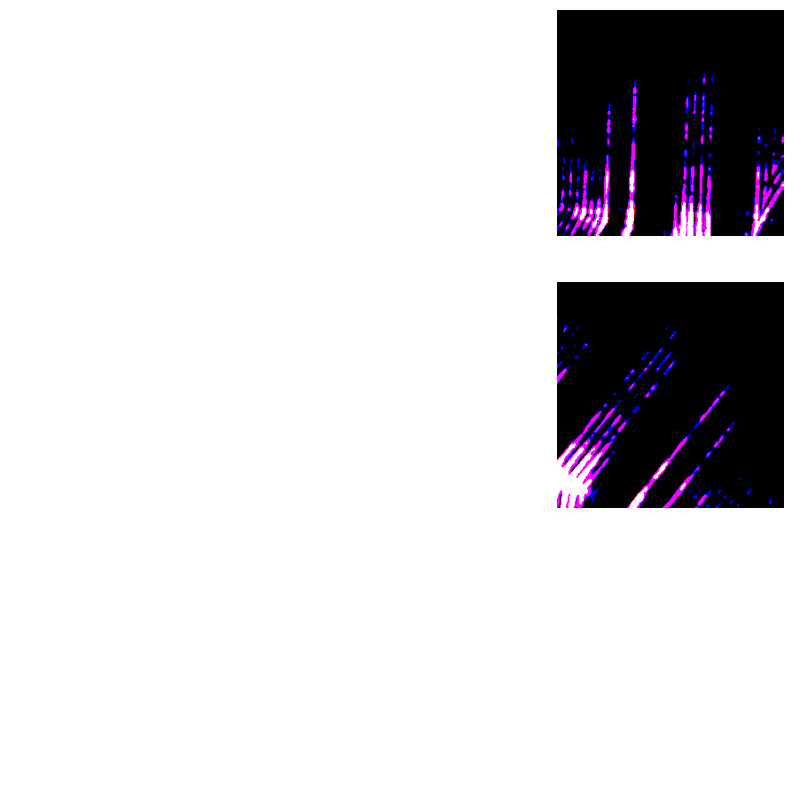

In [ ]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(np.array(augmented_images[0]).astype("float32")))
    plt.axis("off")

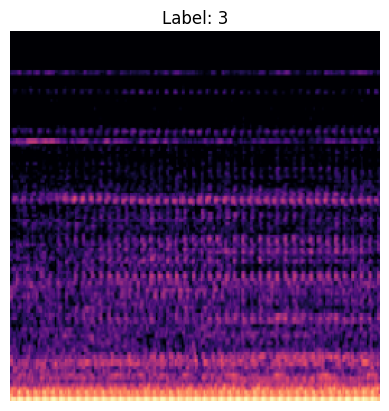

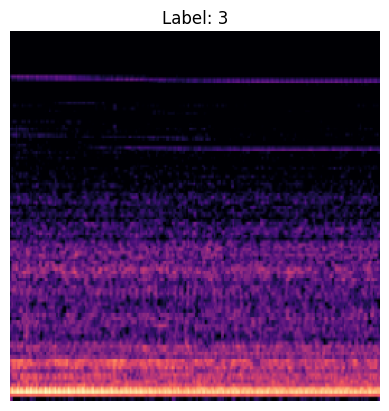

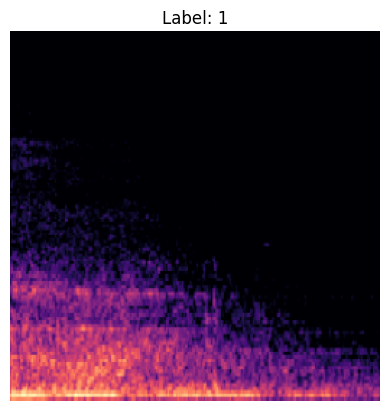

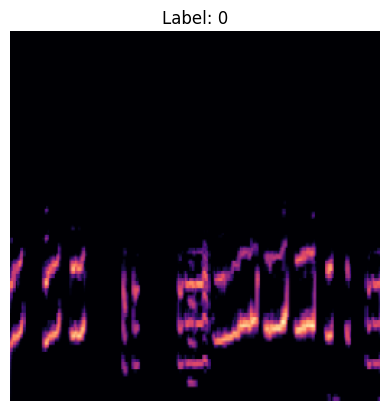

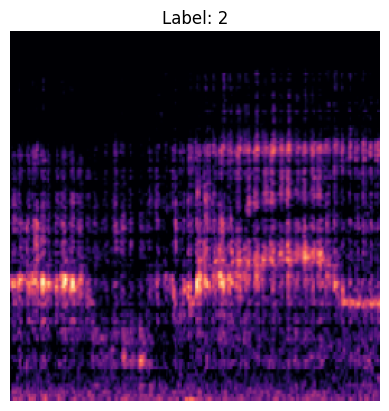

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
        plt.show()


In [ ]:
for x, y in train_ds.take(1):
    print(x.shape, y.shape)

for x, y in val_ds.take(1):
    print(x.shape, y.shape)


(32, 256, 256, 3) (32,)
(32, 256, 256, 3) (32,)


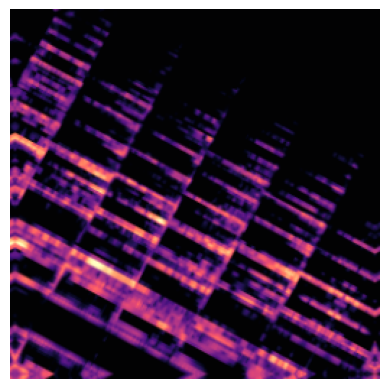

In [ ]:
for images, _ in train_ds.take(1):
  plt.imshow(images[0].numpy().astype("int"))
  plt.axis("off")
  plt.show()

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Global Average Pooling (instead of Flatten)
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])


# Define the optimizer
optimizer = Adam(learning_rate=1e-3)  # Increased learning rate

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,813 (1.65 MB)

 Trainable params: 430,853 (1.64 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

callbacks = [
    early_stopping, lr_scheduler
]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/250


KeyboardInterrupt: 

In [ ]:
# Evaluate CNN model performance
y_true_cnn = []
y_pred_cnn = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_cnn.extend(labels.numpy())
    y_pred_cnn.extend(preds_labels)

# Classification Report for CNN
print("CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, labels=range(num_classes), target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
CNN Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.66      0.71      0.68        68
                          Exterior       0.76      0.49      0.60        59
          Human, non-speech sounds       0.70      0.43      0.54        69
                          Interior       0.59      0.72      0.65        60
Natural soundscapes & water sounds       0.59      0.86      0.70        64

                          accuracy                           0.64       320
                         macro avg       0.66      0.64

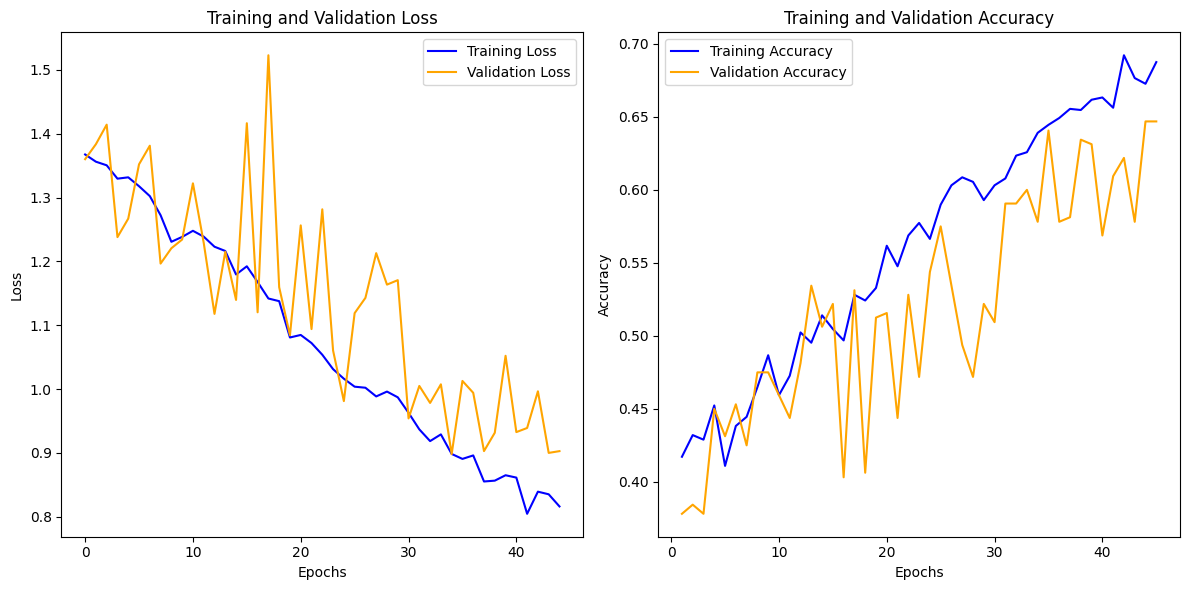

In [ ]:
train_loss = history.history ['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
  layer.trainable = False

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Model
vgg_model = Model(inputs=base_model.input, outputs=x)

In [ ]:
from tensorflow.keras.optimizers import Adam

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_vgg = vgg_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 761ms/step - accuracy: 0.3005 - loss: 3.5095 - val_accuracy: 0.4938 - val_loss: 1.9220 - learning_rate: 0.0010
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 760ms/step - accuracy: 0.4879 - loss: 1.6740 - val_accuracy: 0.5188 - val_loss: 1.2963 - learning_rate: 0.0010
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 741ms/step - accuracy: 0.5783 - loss: 1.1009 - val_accuracy: 0.6375 - val_loss: 0.9958 - learning_rate: 0.0010
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 752ms/step - accuracy: 0.5902 - loss: 1.1239 - val_accuracy: 0.6469 - val_loss: 0.9746 - learning_rate: 0.0010
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 747ms/step - accuracy: 0.6213 - loss: 0.9636 - val_accuracy: 0.5938 - val_loss: 0.9867 - learning_rate: 0.0010
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 753ms/step - accuracy: 0.6820 - loss: 0.8349 - val_accuracy: 0.7094 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 741ms/step - accuracy: 0.6657 - l

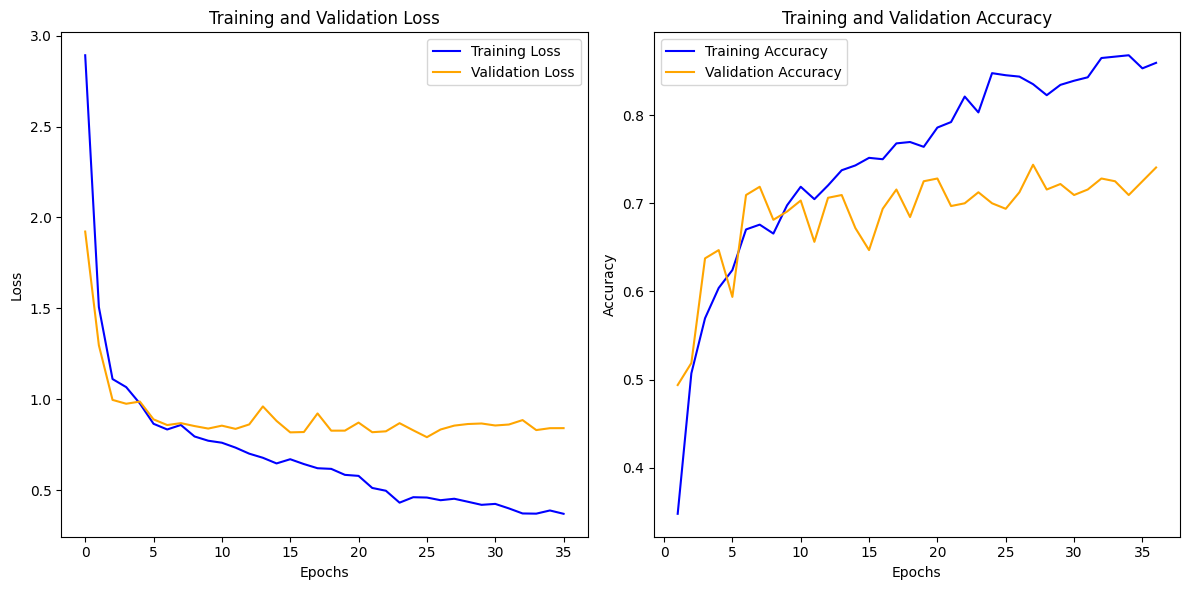

In [ ]:
train_loss = history_vgg.history ['loss']
val_loss = history_vgg.history['val_loss']

train_acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate VGG16 model performance
y_true_vgg = []
y_pred_vgg = []

for images, labels in val_ds:
    preds = vgg_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg.extend(labels.numpy())
    y_pred_vgg.extend(preds_labels)

# Classification Report for VGG16
print("VGG16 Classification Report:")
print(classification_report(y_true_vgg, y_pred_vgg, labels=range(num_classes), target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
VGG16 Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.75      0.72      0.74        68
                          Exterior       0.74      0.68      0.71        59
          Human, non-speech sounds       0.70      0.61      0.65        69
                          Interior       0.69      0.80      0.74        60
Natural soundscapes & water sounds       0.69      0.77      0.73        64

                          accuracy                           0.71       320
                         macro avg       0.71     

In [ ]:
from tensorflow.keras import layers, models

# Define AlexNet architecture
alexnet_model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(256, (5, 5), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(384, (3, 3), padding='same'),
    layers.Activation('relu'),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes),
    layers.Activation('softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile AlexNet model
alexnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train AlexNet
history_alexnet = alexnet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 737ms/step - accuracy: 0.2071 - loss: 68.4802 - val_accuracy: 0.2250 - val_loss: 1.6070 - learning_rate: 0.0010
Epoch 2/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 704ms/step - accuracy: 0.2069 - loss: 1.6317 - val_accuracy: 0.2125 - val_loss: 1.6086 - learning_rate: 0.0010
Epoch 3/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 652ms/step - accuracy: 0.1908 - loss: 1.6143 - val_accuracy: 0.1844 - val_loss: 1.6105 - learning_rate: 0.0010
Epoch 4/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 661ms/step - accuracy: 0.2067 - loss: 1.6106 - val_accuracy: 0.1844 - val_loss: 1.6105 - learning_rate: 0.0010
Epoch 5/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 658ms/step - accuracy: 0.2005 - loss: 1.6104 - val_accuracy: 0.1844 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 6/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 652ms/step - accuracy: 0.2199 - loss: 1.6095 - val_accuracy: 0.1844 - val_loss: 1.6107 - learning_rate: 0.0010
Epoch 7/250
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 638ms/step - accuracy: 0.2110 - 

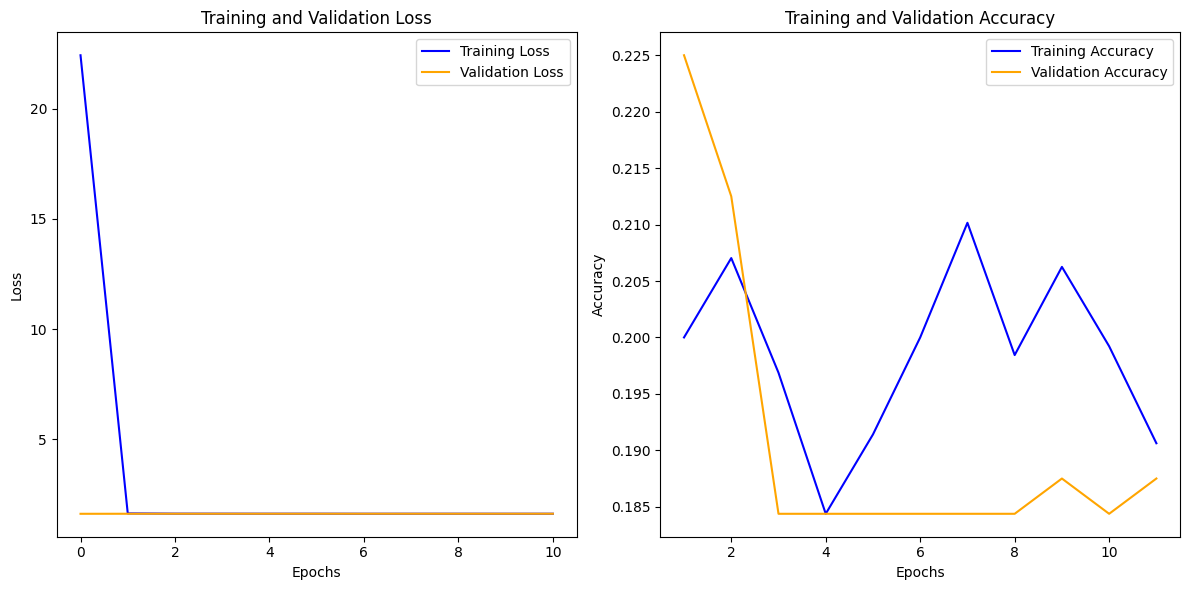

In [ ]:
train_loss = history_alexnet.history ['loss']
val_loss = history_alexnet.history['val_loss']

train_acc = history_alexnet.history['accuracy']
val_acc = history_alexnet.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate AlexNet model performance
y_true_alexnet = []
y_pred_alexnet = []

for images, labels in val_ds:
    preds = alexnet_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_alexnet.extend(labels.numpy())
    y_pred_alexnet.extend(preds_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


In [ ]:
vgg_ish_model = tf.keras.Sequential([
    # Convolutional Block 1
    layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(256, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 4
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.Conv2D(512, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")
])

# Compile the VGG-ish model
vgg_ish_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
vgg_ish_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,431,493 (531.89 MB)

 Trainable params: 139,431,493 (531.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the VGG-ish model
history_vgg_ish = vgg_ish_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=16,
    callbacks=callbacks
)

# Evaluate VGG-ish model performance
y_true_vgg_ish = []
y_pred_vgg_ish = []

for images, labels in val_ds:
    preds = vgg_ish_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg_ish.extend(labels.numpy())
    y_pred_vgg_ish.extend(preds_labels)

# Classification Report for VGG-ish
print("VGG-ish Classification Report:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, labels=range(num_classes), target_names=class_names))


Epoch 1/250


In [ ]:
train_loss = history_vgg_ish.history ['loss']
val_loss = history_vgg_ish.history['val_loss']

train_acc = history_vgg_ish.history['accuracy']
val_acc = history_vgg_ish.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate VGG-ish model performance
y_true_vgg_ish = []
y_pred_vgg_ish = []

for images, labels in val_ds:
    preds = vgg_ish_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg_ish.extend(labels.numpy())
    y_pred_vgg_ish.extend(preds_labels)

# Classification Report for VGG-ish
print("VGG-ish Classification Report:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, labels=range(num_classes), target_names=class_names))


In [ ]:
train_loss = history_vgg_ish.history ['loss']
val_loss = history_vgg_ish.history['val_loss']

train_acc = history_vgg_ish.history['accuracy']
val_acc = history_vgg_ish.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc) + 1), val_acc, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Fine-tune VGG16 model ---
# Unfreeze last 6 convolutional layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Recompile with a lower learning rate
vgg_ft_model = vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

callbacks = [
    early_stopping, lr_scheduler
]

# Fine-tune (you can use fewer epochs, e.g., 30)
history_vgg_finetune = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)



Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 848ms/step - accuracy: 0.9800 - loss: 0.0586 - val_accuracy: 0.8313 - val_loss: 0.8344 - learning_rate: 1.0000e-05
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 757ms/step - accuracy: 0.9845 - loss: 0.0438 - val_accuracy: 0.8250 - val_loss: 0.8171 - learning_rate: 1.0000e-05
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 779ms/step - accuracy: 0.9761 - loss: 0.0603 - val_accuracy: 0.8281 - val_loss: 0.8687 - learning_rate: 1.0000e-05
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 791ms/step - accuracy: 0.9829 - loss: 0.0461 - val_accuracy: 0.8250 - val_loss: 0.8699 - learning_rate: 1.0000e-05
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.9793 - loss: 0.0599 - val_accuracy: 0.8188 - val_loss: 0.8809 - learning_rate: 1.0000e-05
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 758ms/step - accuracy: 0.9869 - loss: 0.0407 - val_accuracy: 0.8281 - val_loss: 0.9052 - learning_rate: 1.0000e-05
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 773ms/step - acc

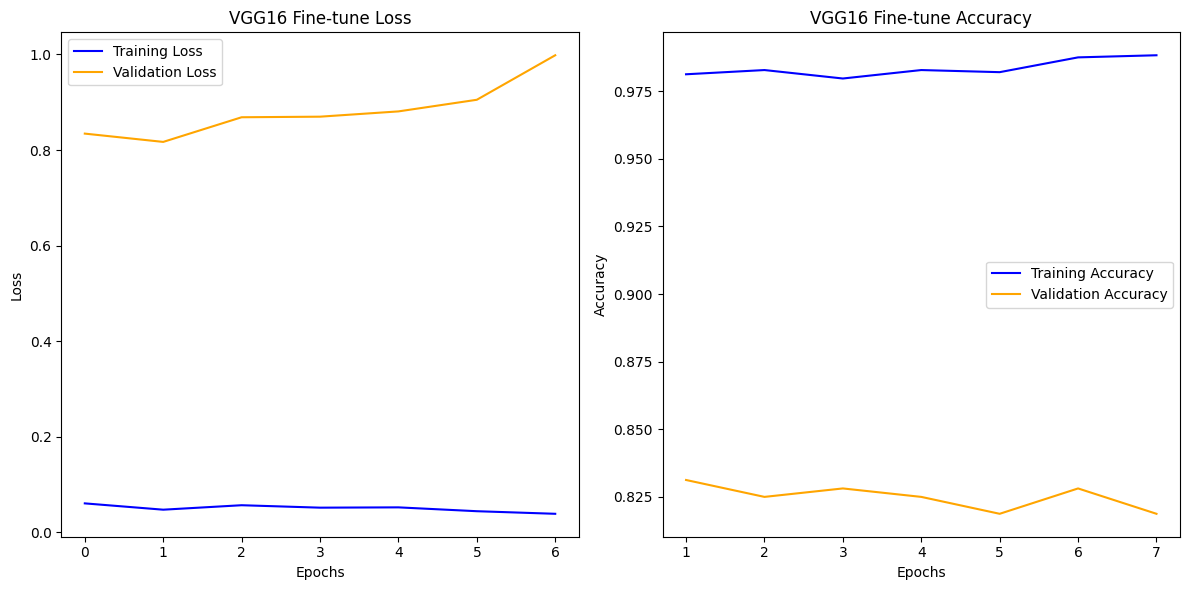

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
VGG-ft Classification Report:
                                    precision    recall  f1-score   support

                           Animals       0.85      0.90      0.87        68
                          Exterior       0.82      0.78      0.80        59
          Human, non-speech sounds       0.86      0.71      0.78        69
                          Interior       0.83      0.87      0.85        60
Natural soundscapes & water sounds       0.78      0.88      0.82        64

                          accuracy                           0.82       320
                         macro avg       0.83 

In [ ]:
# Plot training and validation accuracy/loss for fine-tuning
train_loss_ft = history_vgg_finetune.history['loss']
val_loss_ft = history_vgg_finetune.history['val_loss']
train_acc_ft = history_vgg_finetune.history['accuracy']
val_acc_ft = history_vgg_finetune.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss', color='blue')
plt.plot(val_loss_ft, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Fine-tune Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc_ft) + 1), train_acc_ft, label="Training Accuracy", color="blue")
plt.plot(range(1, len(val_acc_ft) + 1), val_acc_ft, label="Validation Accuracy", color="orange")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Fine-tune Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate VGG-ft model performance
y_true_vgg_ft = []
y_pred_vgg_ft = []

for images, labels in val_ds:
    preds = vgg_model.predict(images)
    preds_labels = np.argmax(preds, axis=1)
    y_true_vgg_ft.extend(labels.numpy())
    y_pred_vgg_ft.extend(preds_labels)

# Classification Report for VGG-ft
print("VGG-ft Classification Report:")
print(classification_report(y_true_vgg_ft, y_pred_vgg_ft, labels=range(num_classes), target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


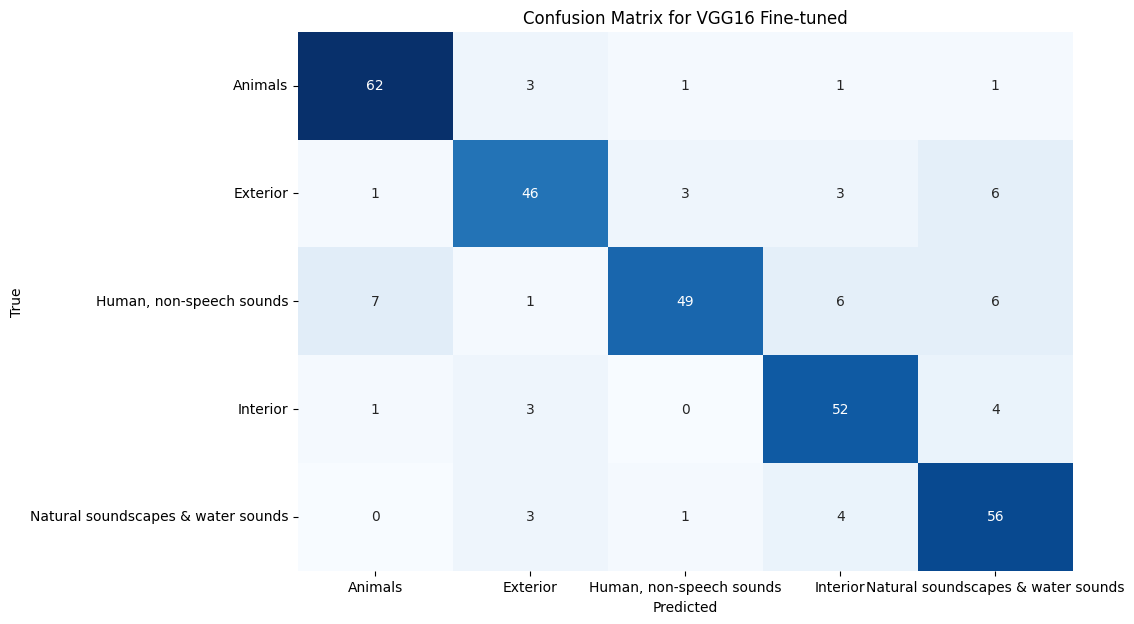

In [ ]:
# Evaluate and print classification report using your function
evaluate_model_and_plot_confusion_matrix(vgg_model, val_ds, class_names, "VGG16 Fine-tuned")

In [ ]:
# CNN Metrics
print("CNN Metrics:")
print(classification_report(y_true_cnn, y_pred_cnn, labels=range(num_classes), target_names=class_names))

# VGG16 Metrics
print("VGG16 Metrics:")
print(classification_report(y_true_vgg, y_pred_vgg, labels=range(num_classes), target_names=class_names))

# AlexNet Metrics
print("AlexNet Metrics:")
print(classification_report(y_true_alexnet, y_pred_alexnet, labels=range(num_classes), target_names=class_names))

# VGG-ish Metrics
print("VGG-ish Metrics:")
print(classification_report(y_true_vgg_ish, y_pred_vgg_ish, labels=range(num_classes), target_names=class_names))


In [ ]:
# Evaluate and plot confusion matrix for CNN model
evaluate_model_and_plot_confusion_matrix(model, val_ds, class_names, "CNN")

# Evaluate and plot confusion matrix for VGG16 model
evaluate_model_and_plot_confusion_matrix(vgg_model, val_ds, class_names, "VGG16")

# Evaluate and plot confusion matrix for AlexNet model
evaluate_model_and_plot_confusion_matrix(alexnet_model, val_ds, class_names, "AlexNet")

# Evaluate and plot confusion matrix for VGG-ish model
evaluate_model_and_plot_confusion_matrix(vgg_ish_model, val_ds, class_names, "VGG-ish")

# Evaluate and print classification report using your function
evaluate_model_and_plot_confusion_matrix(vgg_model, val_ds, class_names, "VGG16 Fine-tuned")